In [1]:
!unzip /content/NYC-stdn.zip

Archive:  /content/NYC-stdn.zip
  inflating: NYC-stdn/╩¤╛▌╦╡├ў.docx  
  inflating: NYC-stdn/volume_test.npz  
  inflating: NYC-stdn/volume_train.npz  


In [2]:
import numpy as np
import pandas as pd
import torch
import torch.utils.data as data
import warnings
import torch
import random
from IPython import display
from matplotlib import pyplot as plt
from PIL import Image
import os
from torch import nn
import torch.optim as optim
from torch.nn import init
import torch.nn.functional as F
import time
from sklearn.utils import shuffle
import math
from sklearn.metrics import mean_squared_error as mse_fn, mean_absolute_error as mae_fn
warnings.filterwarnings("ignore")

In [3]:
class NYCSTDNDataset():
  def __init__(self,data_path,window_size=7) -> None:
    #预测6个时间步的下一个时间步的车流量，data_size=6，label_size=1，加起来为7
    self.window_size = window_size
    self.data = torch.from_numpy(self.loading(data_path)).float()

  def loading(self,data_path):
    #获取流量的数据集
    data = np.load(data_path)['volume']
    # print(data.shape)
    self.max_val,self.min_val = np.max(data),np.min(data)
    #对数据进行滑动窗口操作，分成多个大小为7的短序列数据
    dataset = slidingWindow(data,self.window_size)
    dataset = np.array(dataset).transpose(0,1,4,2,3) #改变序列结构成(1914, 7, 2, 10, 20)
    dataset = dataset.reshape(dataset.shape[0],dataset.shape[1],-1)
    #归一化
    dataset = (dataset - self.min_val) / (self.max_val - self.min_val)
    return dataset
     
  def denormalize(self,x):  #反归一化
    return x * (self.max_val - self.min_val) + self.min_val

#滑动窗口函数
def slidingWindow(seqs,size):
  result = []
  for i in range(seqs.shape[0] - size + 1):
    result.append(seqs[i:i + size,:,:,:]) #(7, 10, 20, 2) 
  # print(np.array(result).shape)
  return result

In [4]:
#绘制曲线
def visualize(num_epochs, train_data, test_data, x_label='epoch', y_label='loss'):
  x = np.arange(0, num_epochs).astype(dtype=np.int)
  # print(x)
  plt.plot(x, train_data, label=f"train_{y_label}", linewidth=1.5)
  plt.plot(x, test_data, label=f"test_{y_label}", linewidth=1.5)
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  plt.legend()
  plt.show()

#绘制均方根、平均绝对误差和平均绝对百分比误差曲线
def plot_metric(score_log):
  score_log = np.array(score_log)

  plt.figure(figsize=(10, 6), dpi=300)
  plt.subplot(2, 2, 1)
  plt.plot(score_log[:, 0], c='#d28ad4')
  plt.ylabel('RMSE')

  plt.subplot(2, 2, 2)
  plt.plot(score_log[:, 1], c='#e765eb')
  plt.ylabel('MAE')

  plt.subplot(2, 2, 3)
  plt.plot(score_log[:, 2], c='#6b016d')
  plt.ylabel('MAPE')

  plt.show()

#用于网络模型和超参数对比的曲线绘制
def Draw_Curve(*args,xlabel = "epoch",ylabel = "loss"):
  for i in args:
    x = np.linspace(0,len(i[0]),len(i[0]))
    plt.plot(x,i[0],label=i[1],linewidth=1.5)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.legend()

In [5]:
train_path = '/content/NYC-stdn/volume_train.npz'
train_set = NYCSTDNDataset(train_path)
print(train_set.data.shape)
test_path = '/content/NYC-stdn/volume_test.npz'
test_set = NYCSTDNDataset(test_path)
print(test_set.data.shape)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.Size([1914, 7, 400])
torch.Size([954, 7, 400])


In [6]:
#mape计算函数
def mape_fn(y, y_pred):
  y, y_pred = np.array(y), np.array(y_pred)
  non_zero_index = (y > 0)
  y = y[non_zero_index]
  y_pred = y_pred[non_zero_index]

  mape = np.abs((y - y_pred) / y)
  mape[np.isinf(mape)] = 0
  return np.mean(mape) * 100

In [7]:
def nextBatch(data,batch_size):
  data_length = len(data)
  num_batches = math.ceil(data_length / batch_size)
  for idx in range(num_batches):
    start_idx = batch_size * idx
    end_idx = min(start_idx + batch_size, data_length)
    yield data[start_idx:end_idx]

In [20]:
class OLSTM(nn.Module):
  def __init__(self,in_channel,out_channels,input_size,hidden_size,output_size,drop_prob):
    super(OLSTM,self).__init__()

    self.convs = nn.Sequential(
      nn.Conv3d(in_channels=in_channel, out_channels=out_channels, kernel_size=(3, 3, 3)),
      nn.MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2)),
      # net2
      # nn.Conv3d(in_channels=out_channels, out_channels=128, kernel_size=(3, 3, 3)),
      # nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))
    )

    # self.lstm = nn.LSTM(input_size=input_size,hidden_size=hidden_size,batch_first=True,num_layers=2)
    # net3
    self.lstm = nn.LSTM(input_size=input_size,hidden_size=hidden_size,batch_first=True,num_layers=3)
    self.dropout = nn.Dropout(drop_prob)
    self.fc = nn.Linear(9216 + hidden_size,output_size)  #64*4*4*9=9216

  def forward(self,x):
    # print(x.shape,end=' ')
    x = x.view(x.shape[0],x.shape[1],2,10,20)
    # print(x.shape,end=' ')

    cnn_feats = self.convs(x.transpose(1,2))
    # print(cnn_feats.shape)
    
    lstm_out,_ = self.lstm(x.view(x.shape[0],x.shape[1],-1))
    lstm_feats =torch.mean(lstm_out,dim=1)
    # print(lstm_feats.shape,end=' ')
    
    #先将cnn的特征图搞成与lstm相同维度，然后进行融合
    fusion_feats = torch.cat((cnn_feats.view(cnn_feats.shape[0],-1),lstm_feats),dim=1)
    # print(fusion_feats.shape)
    # print('=======================')
    x = self.fc(self.dropout(fusion_feats))
    return F.sigmoid(x)


In [9]:
def test(net, data_iter, loss_fn, device='cpu'):
  rmse_score, mae_score, mape_score = 0, 0, 0
  batch_count = 0
  total_loss = 0.0
  y_hats = []
  net.eval()
  with torch.no_grad():
    for batch in nextBatch(data_iter.data, batch_size = 64):
      X,Y = batch[:,:-1,:], batch[:,-1,:]
      X = X.to(device)
      Y = Y.to(device)
      y_hat = net(X)
      total_loss += loss_fn(y_hat,Y).item()
      batch_count += 1
      y_hats.append(y_hat.detach().cpu().numpy())
    y_hats = np.concatenate(y_hats)
  y = data_iter.data[:,-1,:]
  y_hats = data_iter.denormalize(y_hats)
  y = data_iter.denormalize(y)
  y = y.reshape(y.size(0),-1)
  rmse_score = math.sqrt(mse_fn(y, y_hats))
  mae_score = mae_fn(y, y_hats)
  mape_score = mape_fn(y, y_hats)
  return rmse_score, mae_score, mape_score, total_loss/batch_count

In [10]:
def train(net,train_iter,loss_fn,optimizer, device='cpu'):
  net.train()
  for batch in nextBatch(shuffle(train_iter.data),64):
    x,y = batch[:,:-1,:], batch[:,-1,:]
    x = x.to(device)
    y = y.to(device)
    y_hat = net(x)
    l = loss_fn(y_hat, y)
    optimizer.zero_grad(set_to_none=True)
    l.backward()
    optimizer.step()
  train_rmse,train_mae,train_mape,train_loss = test(net,train_iter,loss_fn,device)
  return train_rmse,train_mae,train_mape,train_loss

In [11]:
def main(net, train_iter, test_iter, loss_fn, optimizer, num_epoch, device='cpu'):
  train_loss_list, test_loss_list = [],[]
  train_score_list, test_score_list = [],[]
  best_epoch = 0
  best_test_rmse = 9999
  for epoch in range(num_epoch):
    train_rmse,train_mae,train_mape,train_loss = train(net,train_iter,loss_fn,optimizer,device)
    train_loss_list.append(train_loss)
    train_score_list.append([train_rmse, train_mae, train_mape])

    if epoch==0 or (epoch+1) % 10 == 0:
      print('Epoch: {}, Train_RMSE: {:.4f}, Train_MAE: {:.4f}, Train_MAPE: {:.4f},Train_Loss: {:.8f}'.format(epoch + 1,train_rmse,train_mae,train_mape,train_loss))
    
    test_rmse,test_mae,test_mape,test_loss = test(net,test_iter,loss_fn,device)
    test_loss_list.append(test_loss)
    test_score_list.append([test_rmse,test_mae,test_mape])
    if epoch==0 or (epoch+1) % 10 == 0:
      print('Epoch: {}, Test_RMSE: {:.4f}, Test_MAE: {:.4f}, Test_MAPE: {:.4f},Test_Loss: {:.8f}'.format(epoch + 1,test_rmse,test_mae,test_mape,test_loss))
    if test_rmse < best_test_rmse:
      # print('//////////////////////////////')
      # print(best_test_rmse,test_rmse,end=' ')
      # print('变化')
      # print('//////////////////////////////')
      best_test_rmse = test_rmse
      best_epoch = epoch+1

  # 输出最终训练结果
  print(f'\n{"*" * 40}\nFinal result:')
  print(f'Get best test rmse {np.array(test_score_list)[:, 0].min() :.4f} '
          f'at epoch {best_epoch}')
  print()
  return train_loss_list, test_loss_list, train_score_list, test_score_list

In [12]:
train_iter = NYCSTDNDataset(data_path='NYC-stdn/volume_train.npz')
test_iter = NYCSTDNDataset(data_path='NYC-stdn/volume_test.npz')
print("loading dataset done")

loading dataset done


In [13]:
net = OLSTM(in_channel=2,out_channels=64,input_size=400,hidden_size=64,output_size=400,drop_prob=0.5)

optimizer =  optim.Adam(params=net.parameters(),lr=0.001)
loss_fn = nn.MSELoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = net.to(device)
epochss = 500
train_l_list_a, test_l_list_a = [],[]
train_sc_list_a, test_sc_list_a = [],[]
train_l_list_a, test_l_list_a, train_sc_list_a, test_sc_list_a  = main(net,train_iter,test_iter,loss_fn,optimizer,epochss,device)

Epoch: 1, Train_RMSE: 62.6976, Train_MAE: 23.8517, Train_MAPE: 94.3490,Train_Loss: 0.00238657
Epoch: 1, Test_RMSE: 65.7300, Test_MAE: 25.4963, Test_MAPE: 87.7519,Test_Loss: 0.00260006
Epoch: 10, Train_RMSE: 27.2040, Train_MAE: 11.7215, Train_MAPE: 83.1783,Train_Loss: 0.00044934
Epoch: 10, Test_RMSE: 28.9924, Test_MAE: 12.6089, Test_MAPE: 75.6385,Test_Loss: 0.00050530
Epoch: 20, Train_RMSE: 18.2694, Train_MAE: 8.2972, Train_MAPE: 75.4889,Train_Loss: 0.00020269
Epoch: 20, Test_RMSE: 19.7205, Test_MAE: 8.8209, Test_MAPE: 63.5936,Test_Loss: 0.00023376
Epoch: 30, Train_RMSE: 14.8272, Train_MAE: 6.9104, Train_MAPE: 80.1541,Train_Loss: 0.00013348
Epoch: 30, Test_RMSE: 16.1066, Test_MAE: 7.3007, Test_MAPE: 67.8368,Test_Loss: 0.00015602
Epoch: 40, Train_RMSE: 13.9009, Train_MAE: 6.4531, Train_MAPE: 75.3538,Train_Loss: 0.00011732
Epoch: 40, Test_RMSE: 14.9001, Test_MAE: 6.7429, Test_MAPE: 66.6059,Test_Loss: 0.00013361
Epoch: 50, Train_RMSE: 13.0320, Train_MAE: 5.9060, Train_MAPE: 68.8003,Train_L

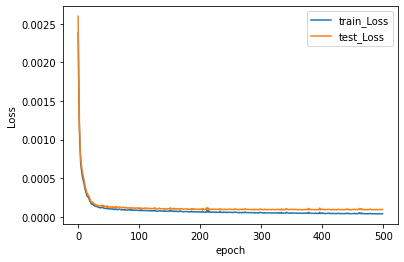

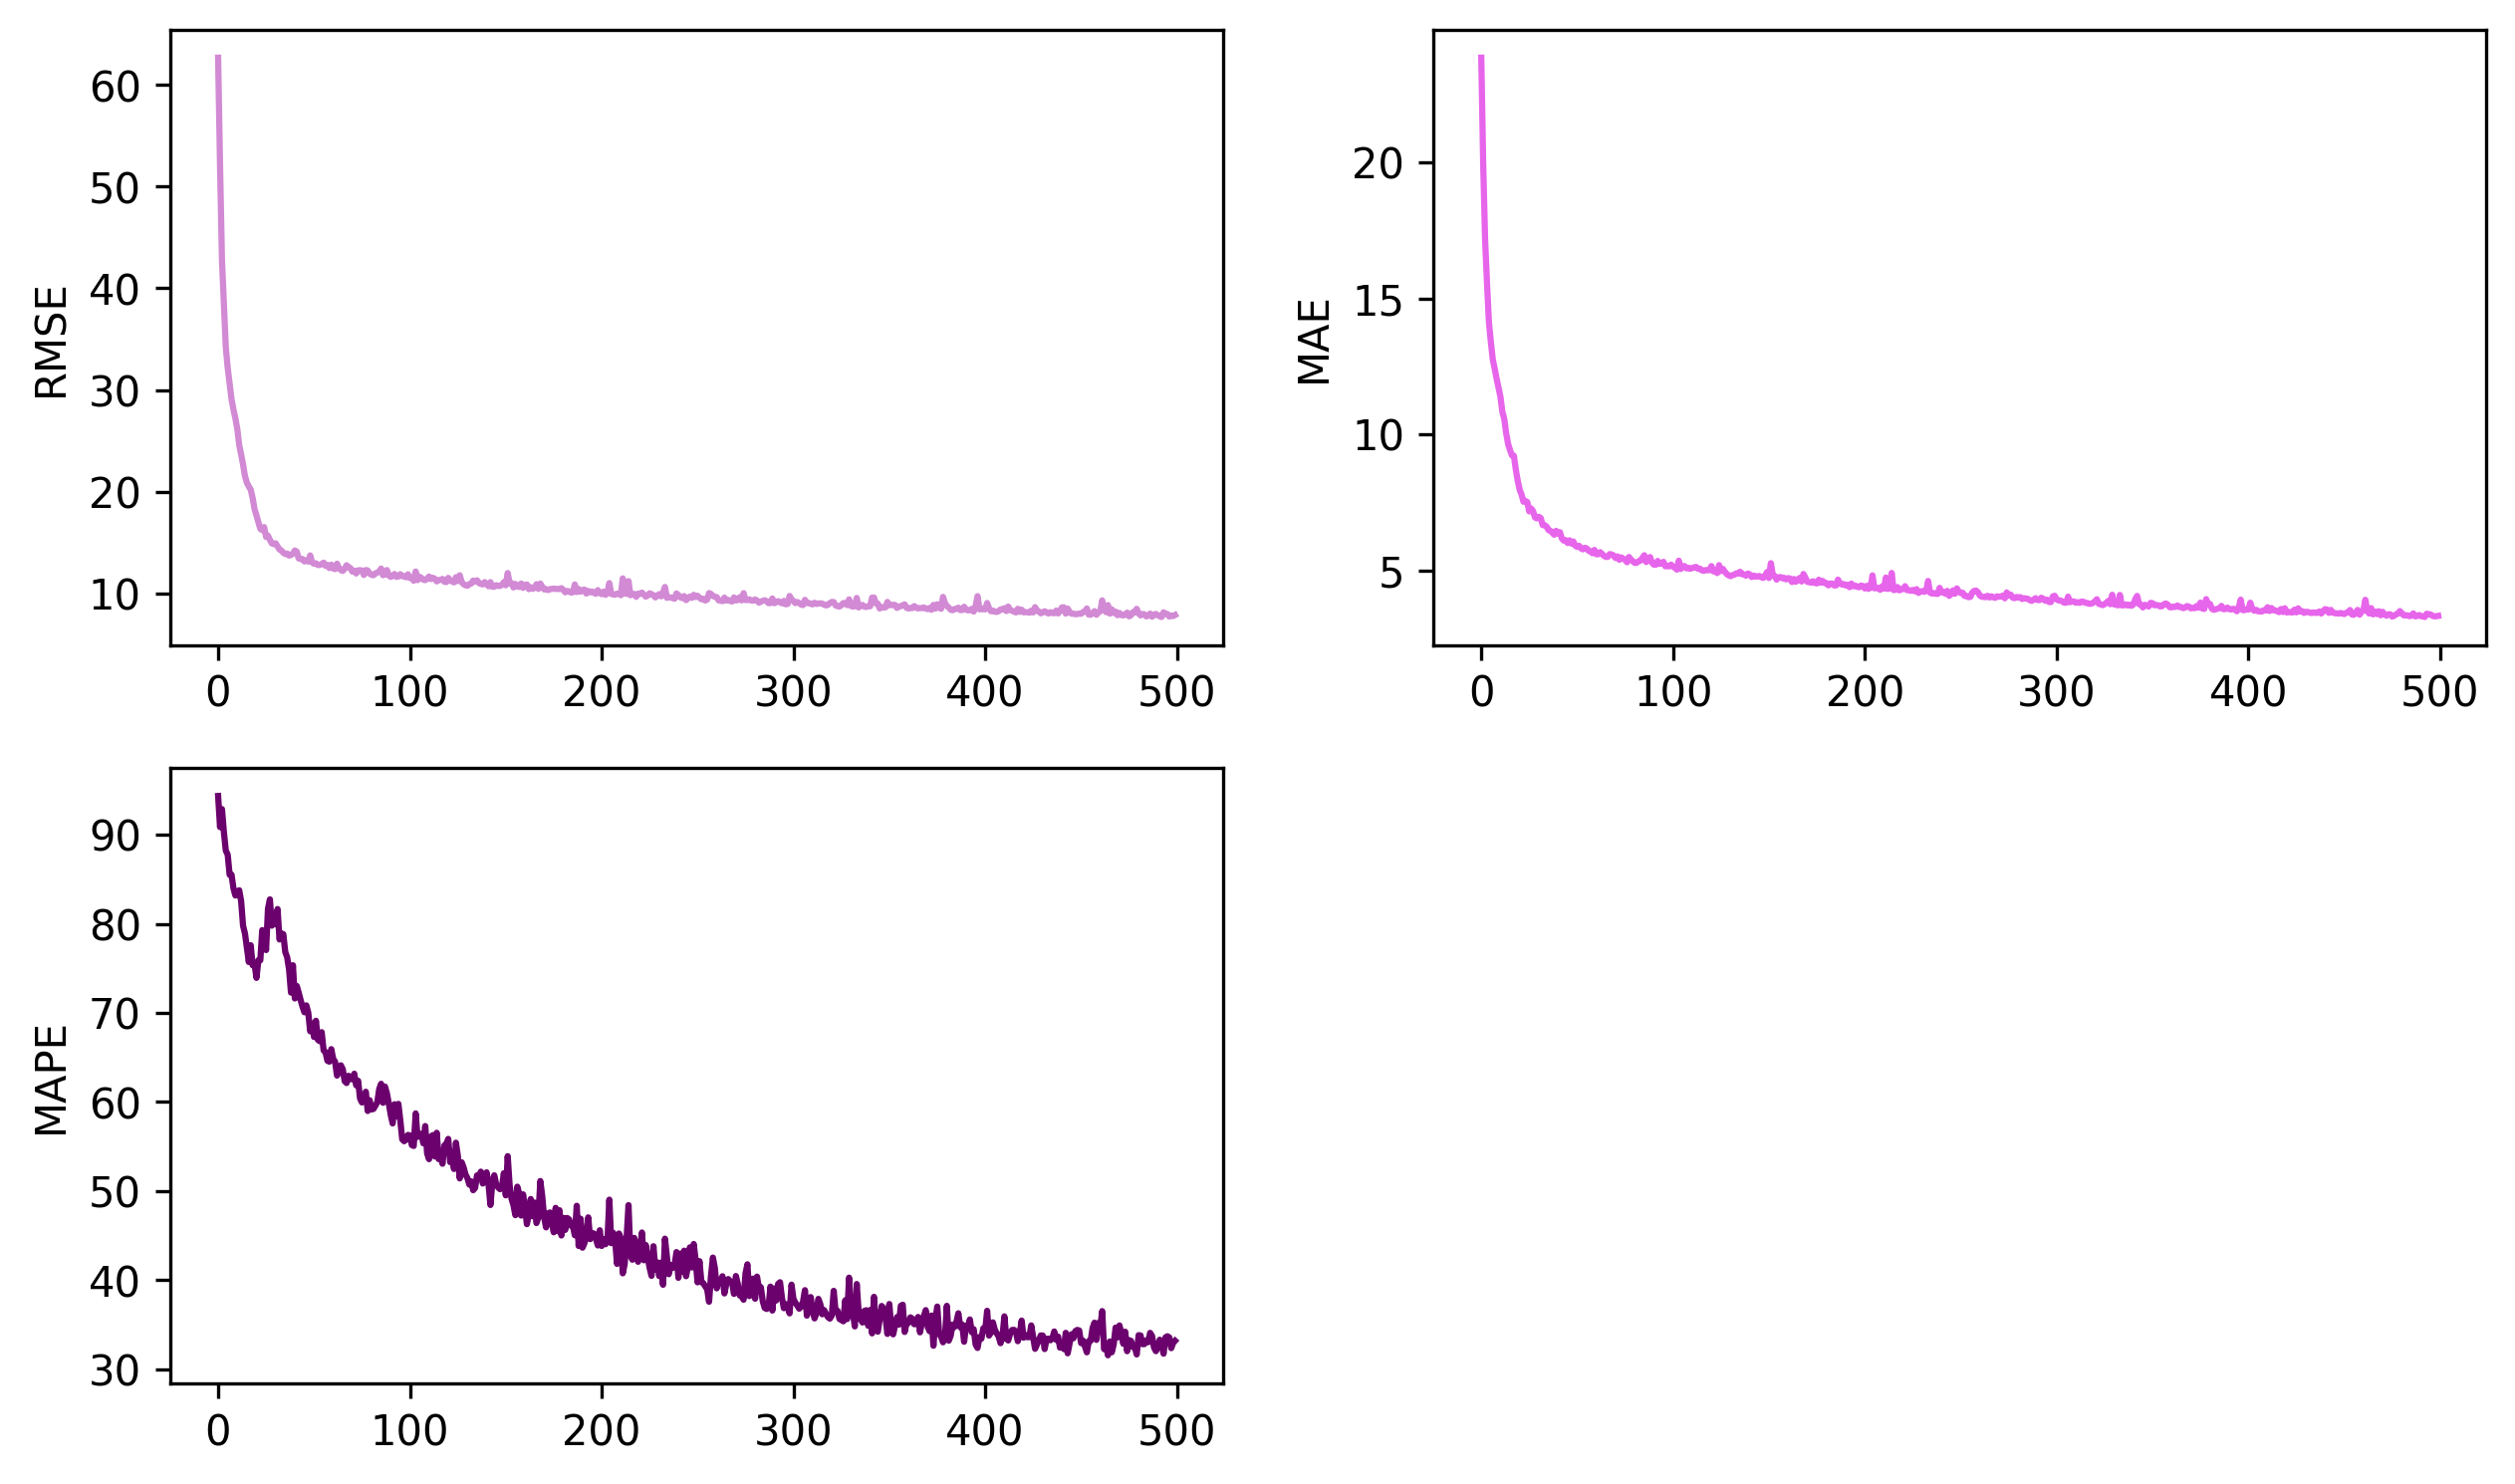

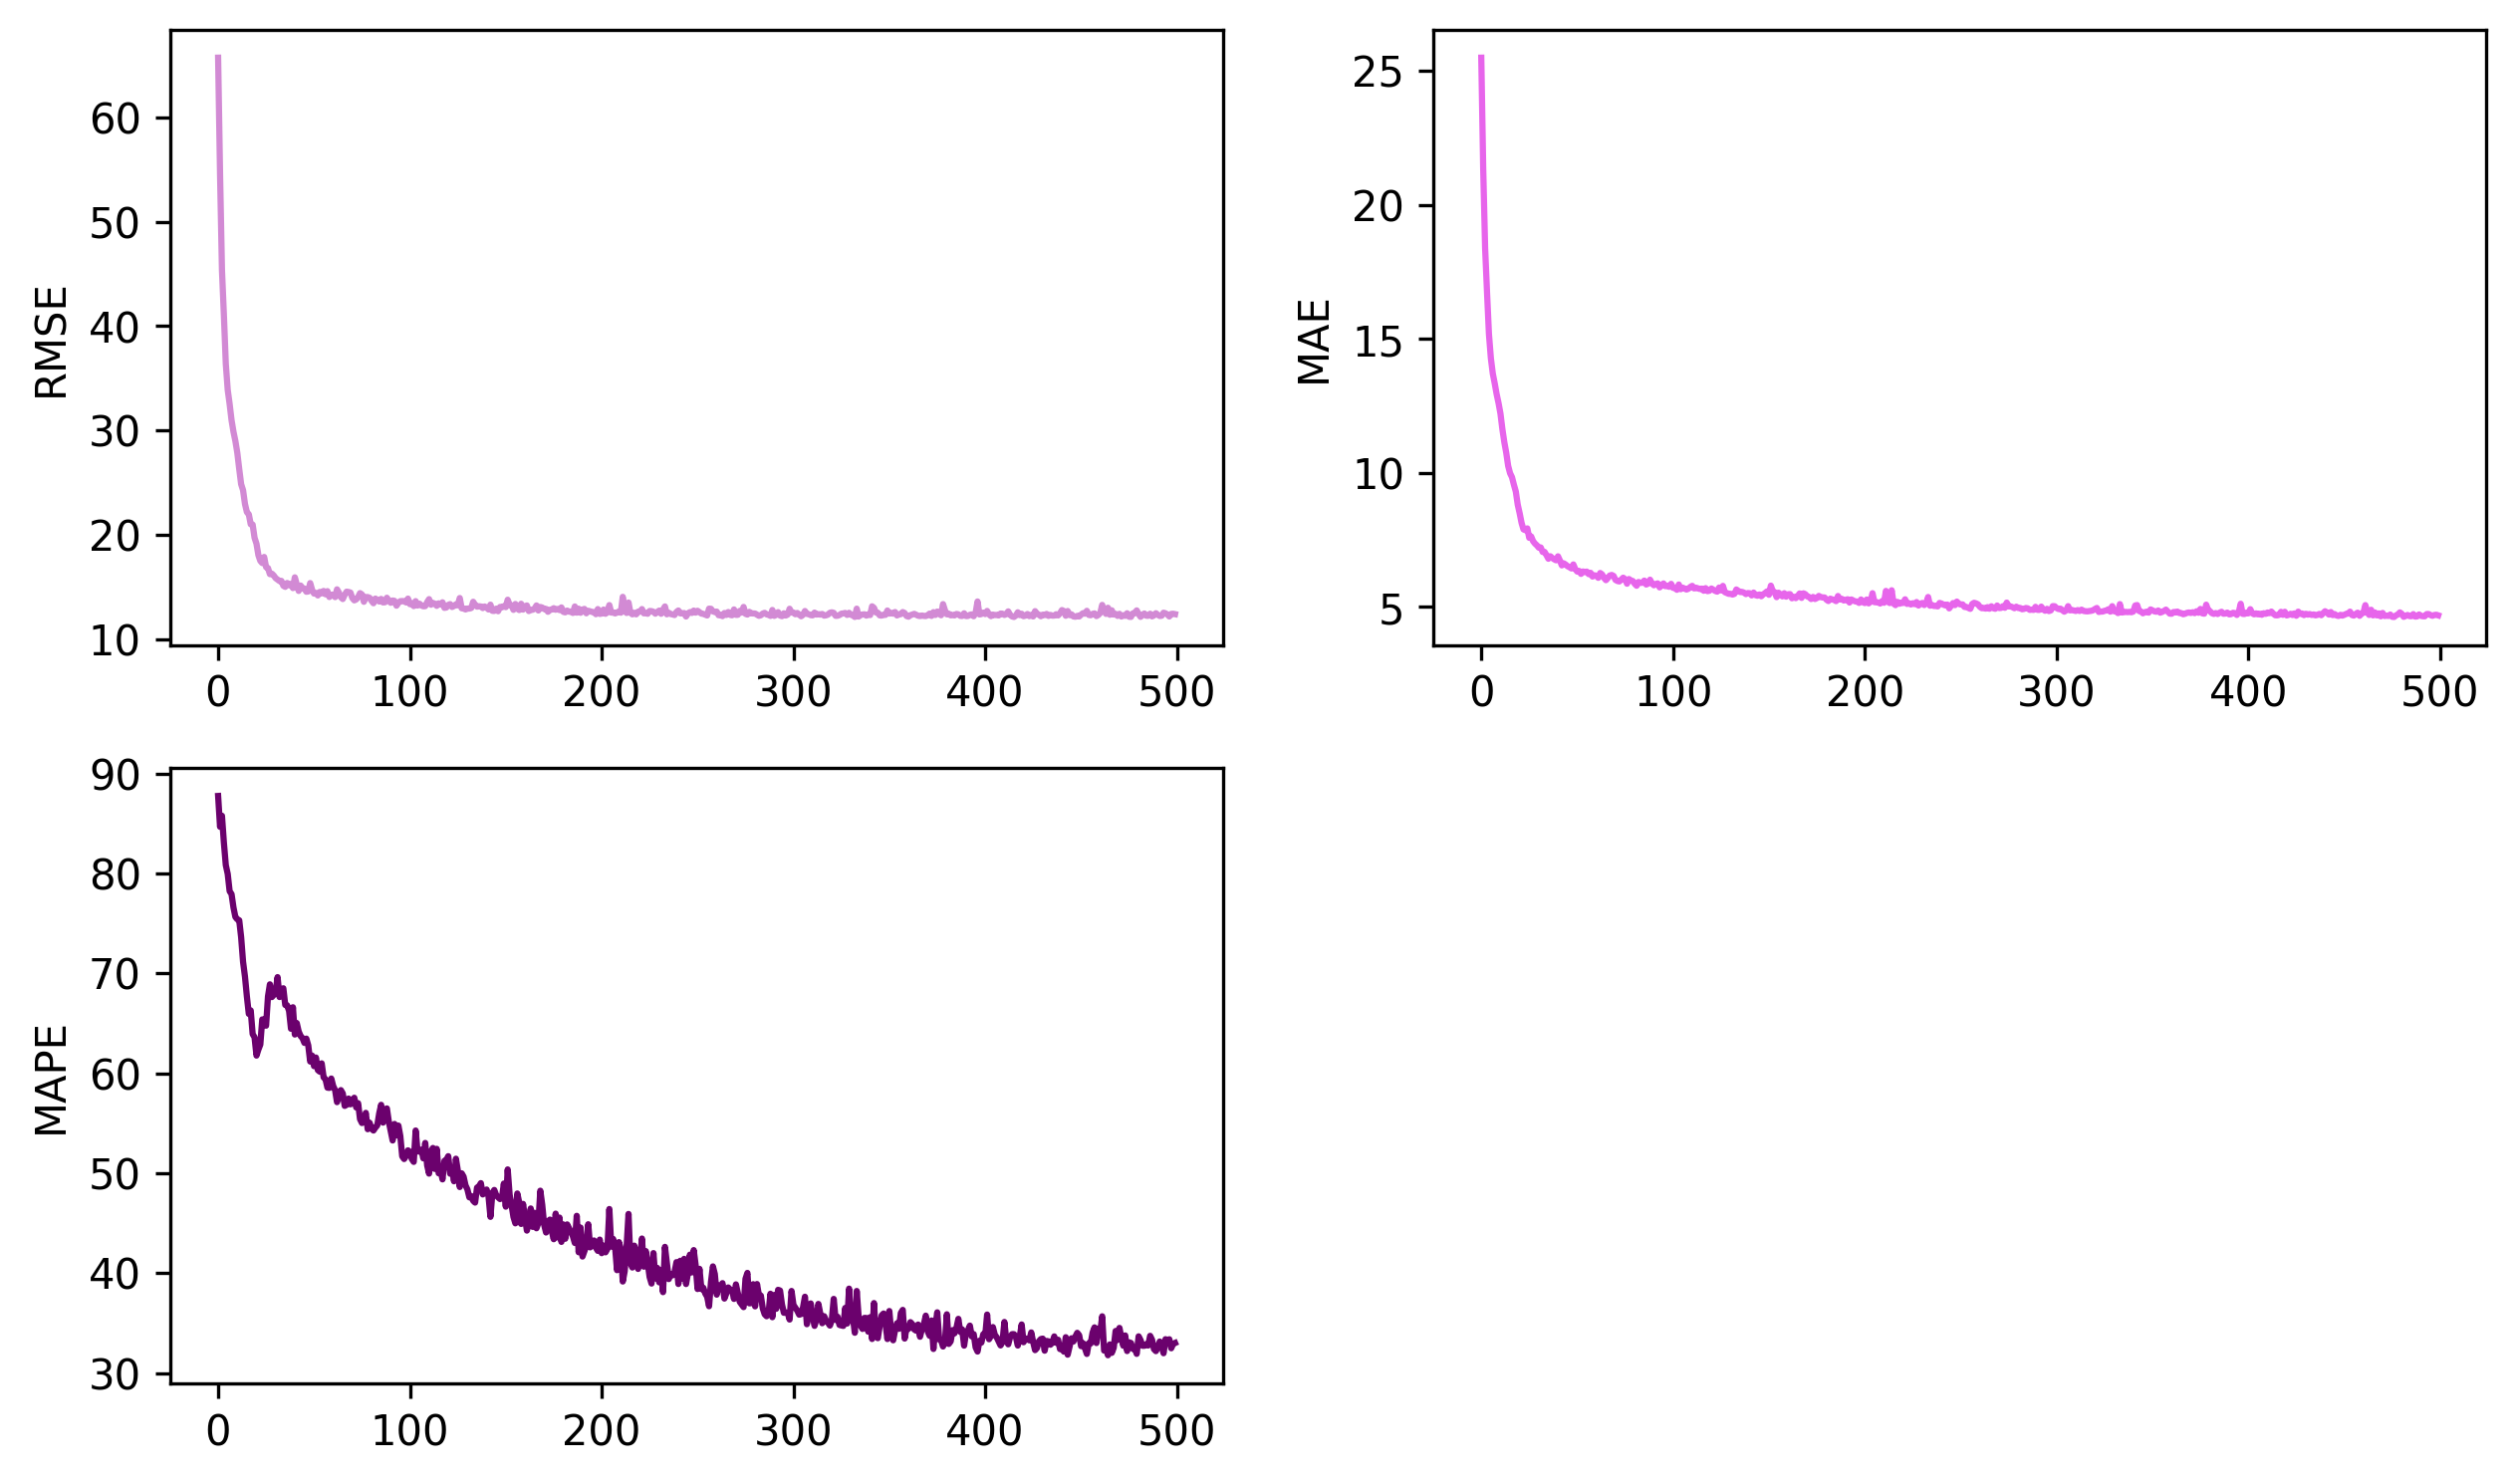

In [14]:
visualize(epochss, train_l_list_a, test_l_list_a, y_label='Loss')
plot_metric(train_sc_list_a)
plot_metric(test_sc_list_a)

In [15]:
net = OLSTM(in_channel=2,out_channels=64,input_size=400,hidden_size=64,output_size=400,drop_prob=0.5)

optimizer =  optim.Adam(params=net.parameters(),lr=0.0001)
loss_fn = nn.MSELoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = net.to(device)
epochss = 500
train_l_list_lrb, test_l_list_lrb = [],[]
train_sc_list_lrb, test_sc_list_lrb = [],[]
train_l_list_lrb, test_l_list_lrb, train_sc_list_lrb, test_sc_list_lrb  = main(net,train_iter,test_iter,loss_fn,optimizer,epochss,device)

Epoch: 1, Train_RMSE: 184.4328, Train_MAE: 175.2092, Train_MAPE: 4742.7357,Train_Loss: 0.02066471
Epoch: 1, Test_RMSE: 179.4383, Test_MAE: 170.3562, Test_MAPE: 4475.5707,Test_Loss: 0.01937785
Epoch: 10, Train_RMSE: 39.2981, Train_MAE: 27.0624, Train_MAPE: 551.4587,Train_Loss: 0.00093796
Epoch: 10, Test_RMSE: 38.8647, Test_MAE: 25.7935, Test_MAPE: 480.0566,Test_Loss: 0.00090830
Epoch: 20, Train_RMSE: 28.5464, Train_MAE: 16.3250, Train_MAPE: 266.5140,Train_Loss: 0.00049483
Epoch: 20, Test_RMSE: 29.2550, Test_MAE: 16.0163, Test_MAPE: 225.9608,Test_Loss: 0.00051457
Epoch: 30, Train_RMSE: 25.1286, Train_MAE: 13.2139, Train_MAPE: 193.5475,Train_Loss: 0.00038343
Epoch: 30, Test_RMSE: 26.0702, Test_MAE: 13.1473, Test_MAPE: 162.0471,Test_Loss: 0.00040857
Epoch: 40, Train_RMSE: 23.1173, Train_MAE: 11.5793, Train_MAPE: 158.1909,Train_Loss: 0.00032450
Epoch: 40, Test_RMSE: 23.9362, Test_MAE: 11.5680, Test_MAPE: 131.3972,Test_Loss: 0.00034446
Epoch: 50, Train_RMSE: 21.8454, Train_MAE: 10.5417, Trai

In [16]:
net = OLSTM(in_channel=2,out_channels=64,input_size=400,hidden_size=64,output_size=400,drop_prob=0.5)

optimizer =  optim.Adam(params=net.parameters(),lr=0.01)
loss_fn = nn.MSELoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = net.to(device)
epochss = 500
train_l_list_lrc, test_l_list_lrc = [],[]
train_sc_list_lrc, test_sc_list_lrc = [],[]
train_l_list_lrc, test_l_list_lrc, train_sc_list_lrc, test_sc_list_lrc  = main(net,train_iter,test_iter,loss_fn,optimizer,epochss,device)

Epoch: 1, Train_RMSE: 108.8342, Train_MAE: 37.6981, Train_MAPE: 100.0000,Train_Loss: 0.00719224
Epoch: 1, Test_RMSE: 115.1950, Test_MAE: 41.0661, Test_MAPE: 100.0000,Test_Loss: 0.00797936
Epoch: 10, Train_RMSE: 108.8342, Train_MAE: 37.6981, Train_MAPE: 100.0000,Train_Loss: 0.00719224
Epoch: 10, Test_RMSE: 115.1950, Test_MAE: 41.0661, Test_MAPE: 100.0000,Test_Loss: 0.00797936
Epoch: 20, Train_RMSE: 108.8342, Train_MAE: 37.6981, Train_MAPE: 100.0000,Train_Loss: 0.00719224
Epoch: 20, Test_RMSE: 115.1950, Test_MAE: 41.0661, Test_MAPE: 100.0000,Test_Loss: 0.00797936
Epoch: 30, Train_RMSE: 108.8342, Train_MAE: 37.6981, Train_MAPE: 100.0000,Train_Loss: 0.00719224
Epoch: 30, Test_RMSE: 115.1950, Test_MAE: 41.0661, Test_MAPE: 100.0000,Test_Loss: 0.00797936
Epoch: 40, Train_RMSE: 108.8342, Train_MAE: 37.6981, Train_MAPE: 100.0000,Train_Loss: 0.00719224
Epoch: 40, Test_RMSE: 115.1950, Test_MAE: 41.0661, Test_MAPE: 100.0000,Test_Loss: 0.00797936
Epoch: 50, Train_RMSE: 108.8342, Train_MAE: 37.6981,

In [19]:
net = OLSTM(in_channel=2,out_channels=64,input_size=400,hidden_size=64,output_size=400,drop_prob=0.5)

optimizer =  optim.Adam(params=net.parameters(),lr=0.001)
loss_fn = nn.MSELoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = net.to(device)
epochss = 500
train_l_list_net2, test_l_list_net2 = [],[]
train_sc_list_net2, test_sc_list_net2 = [],[]
train_l_list_net2, test_l_list_net2, train_sc_list_net2, test_sc_list_net2  = main(net,train_iter,test_iter,loss_fn,optimizer,epochss,device)

Epoch: 1, Train_RMSE: 93.5764, Train_MAE: 33.6301, Train_MAPE: 105.3085,Train_Loss: 0.00531626
Epoch: 1, Test_RMSE: 99.1184, Test_MAE: 36.6315, Test_MAPE: 99.5974,Test_Loss: 0.00590843
Epoch: 10, Train_RMSE: 25.1125, Train_MAE: 11.8338, Train_MAPE: 138.5608,Train_Loss: 0.00038294
Epoch: 10, Test_RMSE: 26.4798, Test_MAE: 12.6417, Test_MAPE: 136.0025,Test_Loss: 0.00042168
Epoch: 20, Train_RMSE: 21.8004, Train_MAE: 9.0973, Train_MAPE: 77.8062,Train_Loss: 0.00028854
Epoch: 20, Test_RMSE: 23.7994, Test_MAE: 9.9894, Test_MAPE: 71.8321,Test_Loss: 0.00034056
Epoch: 30, Train_RMSE: 17.6723, Train_MAE: 7.3698, Train_MAPE: 67.4680,Train_Loss: 0.00018960
Epoch: 30, Test_RMSE: 18.9350, Test_MAE: 7.9598, Test_MAPE: 60.4725,Test_Loss: 0.00021560
Epoch: 40, Train_RMSE: 16.4122, Train_MAE: 6.6757, Train_MAPE: 58.1289,Train_Loss: 0.00016350
Epoch: 40, Test_RMSE: 17.8382, Test_MAE: 7.2979, Test_MAPE: 52.7253,Test_Loss: 0.00019139
Epoch: 50, Train_RMSE: 17.5157, Train_MAE: 7.0351, Train_MAPE: 58.6729,Trai

In [21]:
net = OLSTM(in_channel=2,out_channels=64,input_size=400,hidden_size=64,output_size=400,drop_prob=0.5)

optimizer =  optim.Adam(params=net.parameters(),lr=0.001)
loss_fn = nn.MSELoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = net.to(device)
epochss = 500
train_l_list_net3, test_l_list_net3 = [],[]
train_sc_list_net3, test_sc_list_net3 = [],[]
train_l_list_net3, test_l_list_net3, train_sc_list_net3, test_sc_list_net3  = main(net,train_iter,test_iter,loss_fn,optimizer,epochss,device)

Epoch: 1, Train_RMSE: 65.2807, Train_MAE: 24.4766, Train_MAPE: 93.8184,Train_Loss: 0.00258710
Epoch: 1, Test_RMSE: 68.8673, Test_MAE: 26.4347, Test_MAPE: 89.1641,Test_Loss: 0.00285481
Epoch: 10, Train_RMSE: 27.8276, Train_MAE: 11.8233, Train_MAPE: 82.2237,Train_Loss: 0.00047020
Epoch: 10, Test_RMSE: 29.6515, Test_MAE: 12.7630, Test_MAPE: 75.6498,Test_Loss: 0.00052844
Epoch: 20, Train_RMSE: 18.6192, Train_MAE: 8.2274, Train_MAPE: 64.8004,Train_Loss: 0.00021053
Epoch: 20, Test_RMSE: 19.9582, Test_MAE: 8.7935, Test_MAPE: 56.5760,Test_Loss: 0.00023946
Epoch: 30, Train_RMSE: 15.7801, Train_MAE: 7.0659, Train_MAPE: 72.7937,Train_Loss: 0.00015118
Epoch: 30, Test_RMSE: 16.4933, Test_MAE: 7.3159, Test_MAPE: 62.7247,Test_Loss: 0.00016363
Epoch: 40, Train_RMSE: 13.5393, Train_MAE: 6.0965, Train_MAPE: 67.0289,Train_Loss: 0.00011130
Epoch: 40, Test_RMSE: 15.1020, Test_MAE: 6.6057, Test_MAPE: 61.3344,Test_Loss: 0.00013715
Epoch: 50, Train_RMSE: 13.0547, Train_MAE: 5.8667, Train_MAPE: 67.3273,Train_L

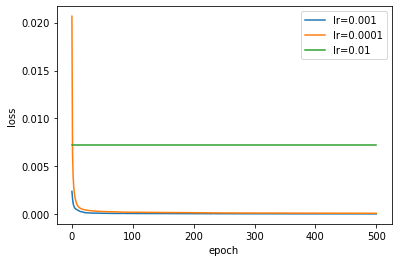

In [24]:
#loss
Draw_Curve([train_l_list_a,"lr=0.001"],[train_l_list_lrb,"lr=0.0001"],
           [train_l_list_lrc,"lr=0.01"],ylabel = "loss")

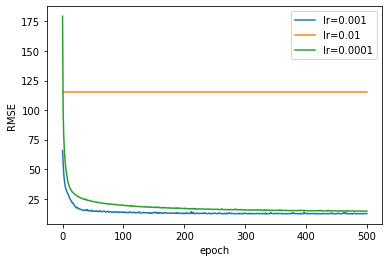

In [23]:
# 对准确率进行对比实验
dataa = np.array(test_sc_list_a)
data_l2 = np.array(test_sc_list_lrb)
data_l3 = np.array(test_sc_list_lrc)

#RMSE
Draw_Curve([dataa[:,0],"lr=0.001"],[data_l3[:,0],"lr=0.01"],
           [data_l2[:,0],"lr=0.0001"],ylabel = "RMSE")

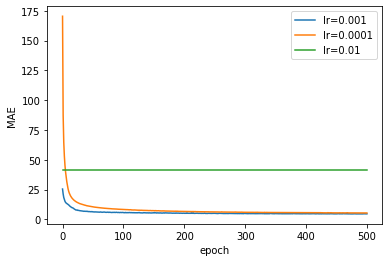

In [27]:
#MAE
Draw_Curve([dataa[:,1],"lr=0.001"],[data_l2[:,1],"lr=0.0001"],
           [data_l3[:,1],"lr=0.01"],ylabel = "MAE")

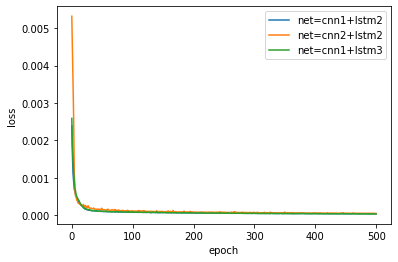

In [28]:
# 对网络进行对比实验
# loss

Draw_Curve([train_l_list_a,"net=cnn1+lstm2"],[train_l_list_net2,"net=cnn2+lstm2"],
           [train_l_list_net3,"net=cnn1+lstm3"],ylabel = "loss")

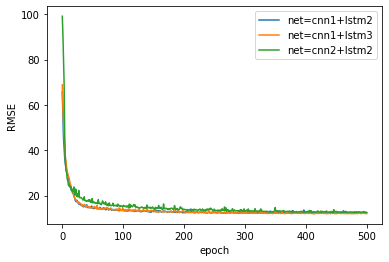

In [29]:

dataa = np.array(test_sc_list_a)
data_l2 = np.array(test_sc_list_net2)
data_l3 = np.array(test_sc_list_net3)

#RMSE
Draw_Curve([dataa[:,0],"net=cnn1+lstm2"],[data_l3[:,0],"net=cnn1+lstm3"],
           [data_l2[:,0],"net=cnn2+lstm2"],ylabel = "RMSE")

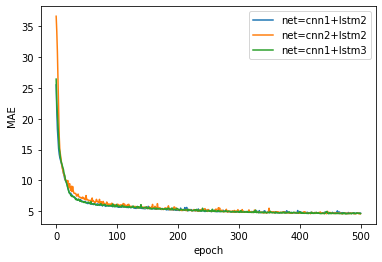

In [30]:
#MAE
Draw_Curve([dataa[:,1],"net=cnn1+lstm2"],[data_l2[:,1],"net=cnn2+lstm2"],
           [data_l3[:,1],"net=cnn1+lstm3"],ylabel = "MAE")